In [3]:
import torch
import torchvision
import xml.etree.ElementTree as ET
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


In [2]:
pip install matplot


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached websocket_client-1.8.0-py3-none-any.whl.metadata (8.0 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached charset_normalizer-3.4.1-cp313-cp313-macosx_10_13_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
  Using cached markdown_it_py-3.0.0-py

In [4]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
voc_root = "./voc/VOCdevkit/VOC2012"
img_folder = f"{voc_root}/JPEGImages"
ann_folder = f"{voc_root}/Annotations"

In [8]:
img_files = sorted(os.listdir(img_folder))
ann_files = sorted(os.listdir(ann_folder))
print(f"Total images: {len(img_files)}")
print(f"Total annotations: {len(ann_files)}")
assert len(img_files) == len(ann_files)

Total images: 17125
Total annotations: 17125


In [12]:
img_name = img_files[0]
img_path = os.path.join(img_folder, img_name)
ann_path = os.path.join(ann_folder, img_name.replace(".jpg", ".xml"))

In [13]:
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [14]:
# parse XML for bounding boxes
tree = ET.parse(ann_path)
root = tree.getroot()

In [17]:
bboxes = []
labels = []
for obj in root.findall("object"):
    label = obj.find("name").text
    bbox = obj.find("bndbox")
    xmin = int(bbox.find("xmin").text)
    ymin = int(bbox.find("ymin").text)
    xmax = int(bbox.find("xmax").text)
    ymax = int(bbox.find("ymax").text)
    bboxes.append([xmin, ymin, xmax, ymax])
    labels.append(label)
print(f"Bounding boxes: {bboxes}")
print(f"Labels: {labels}")

Bounding boxes: [[174, 101, 349, 351]]
Labels: ['person']


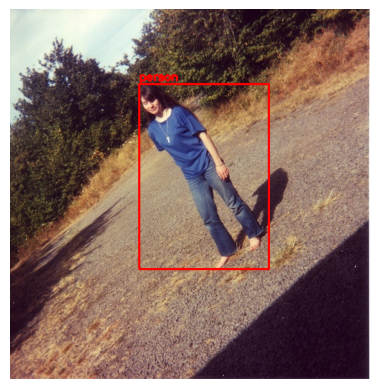

In [18]:
# Draw bounding boxes
for bbox, label in zip(bboxes, labels):
    xmin, ymin, xmax, ymax = bbox
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    cv2.putText(image, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.imshow(image)
plt.axis("off")
plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [26]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 4)
    
    def forward(self, x):
        # todo: shapeshifter
        shapes = []
        shapes.append(("input", x.shape))
        x = self.conv1(x)
        x = F.relu(x)
        shapes.append(("after conv1", x.shape))
        x = self.conv2(x)
        x = F.relu(x)
        shapes.append(("after conv2", x.shape))
        x = F.adaptive_avg_pool2d(x, (64, 64))
        shapes.append(("after pooling", x.shape))
        x = torch.flatten(x, start_dim=1)
        shapes.append(("after flatten", x.shape))
        x = self.fc1(x)
        x = F.relu(x)
        shapes.append(("after fc1", x.shape))
        x = self.fc2(x)
        shapes.append(("final output (bounding box)", x.shape))
        return x, shapes


In [27]:
model = TinyCNN()
dummy_input = torch.randn(1, 3, 128, 128)
output, shape_log = model(dummy_input)

In [28]:
for name, shape in shape_log:
    print(f"{name}: {shape}")

input: torch.Size([1, 3, 128, 128])
after conv1: torch.Size([1, 8, 128, 128])
after conv2: torch.Size([1, 16, 128, 128])
after pooling: torch.Size([1, 16, 64, 64])
after flatten: torch.Size([1, 65536])
after fc1: torch.Size([1, 128])
final output (bounding box): torch.Size([1, 4])


In [31]:
pip install torchviz

  Using cached torchviz-0.0.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached torchviz-0.0.3-py3-none-any.whl (5.7 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [37]:
import torch
import torch.nn as nn
import torchviz

# simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.fc = nn.Linear(16 * 32 * 32,  10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [41]:
model = SimpleCNN()
dummy_input = torch.randn(1, 3, 32, 32)
output = model(dummy_input)
dot = torchviz.make_dot(output, params=dict(model.named_parameters()))
dot.format = "png"
dot.render("cnn_graph")

'cnn_graph.png'

train a model with the VOC dataset

In [42]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [66]:
#load dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = datasets.VOCDetection(root='path_to_voc', year='2012', image_set='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

NameError: name 'datasets' is not defined

In [59]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]  # Keep as list due to variable sizes
    return images, targets

train_loader = DataLoader(voc_dataset, batch_size=4, collate_fn=collate_fn)

In [61]:
#define model, optimizer, and loss
model = SimpleCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [65]:
for epoch in range(5):
    model.train()
    for images, targets in train_loader:
        # Convert list of PIL images to a tensor batch (assuming each image is a PIL Image)
        images = torch.stack([transforms.ToTensor()(img) for img in images])
        
        # Check shape of images (should be (batch_size, 3, 224, 224))
        print(images.shape)  

        # Ensure the labels are in the correct format for bounding boxes (x1, y1, x2, y2)
        labels = [list(map(int, t["annotation"]["object"][0]["bndbox"].values())) for t in targets]
        labels = torch.tensor(labels, dtype=torch.float32)  # Shape should be (batch_size, 4)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)  # Model output for batch
        
        # Assuming the model outputs the predicted bounding box (batch_size, 4)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")




        

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>